In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
from typing import List, Tuple
import uproot3

In [2]:
input_VF = '/scratch/user/adegenna/top50_standard/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_VertexingDebug.root'
input_sigmaX = '/scratch/user/adegenna/top50_all_xrescaled/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_VertexingDebug.root'

In [3]:
save_plots = True
black_and_white = True
show_titles = False
thick_hist_lines = False

## Pick what extra branches you want
with_dtf = True
with_pidsubs = False
with_protoparticles = True
with_2Ddebug = True
with_truevtx_kinematics = True

## Perform analysis with:
## - All data: 'b' (both)
## - Only Lambdas: 'm' (matter)
## - Only antiLambdas: 'a' (antimatter)
use_matter_antimatter = 'b'

In [4]:
if use_matter_antimatter == 'b':
    proton_symbol = 'p'
    pion_symbol = '\pi'
    file_suffix = ''
elif use_matter_antimatter == 'm':
    proton_symbol = 'p'
    pion_symbol = '\pi^-'
    file_suffix = '_matter'
elif use_matter_antimatter == 'a':
    proton_symbol = '\bar{p}'
    pion_symbol = '\pi^+'
    file_suffix = '_antimatter'
else:
    raise ValueError

In [5]:
## Create plots directory, if missing
plots_dir = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/'
                  + 'plots/'
                  + 'E_studies_on_integrated_root_files/'
                  + 'vertex_fitter_vs_sigmax_rescaled_algorithm_comparison/'
)
pathlib.Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Data import quasi-class (v.3.0)

In [6]:
def root_file_to_df(
    filename: str,
    branches_ordinary: List[str] = [],
    branches_jagged: List[str] = [],   ## These are the protoparticles, really
    truth_tree: bool = False,
    slice_ordinary: bool = True
) -> pd.DataFrame:
    if len(branches_jagged) == 0:
        have_jagged = False
    else:
        have_jagged = True
    
    if len(branches_ordinary) == 0:
        have_ordinary = False
    else:
        have_ordinary = True
    
    with uproot3.open(filename) as file_root:
        if truth_tree:
            tree = file_root['Lb_MC/MCDecayTree']
        else:
            tree = file_root['Lb_T/DecayTree']
        ## Load dataFrame with desired branches
        if have_ordinary:
            if slice_ordinary:
                df_ord = tree.pandas.df(branches_ordinary).loc[(slice(None), 0), :]
            else:
                df_ord = tree.pandas.df(branches_ordinary)
        if have_jagged:
            df_jag = tree.pandas.df(branches_jagged, flatten=False)
            for col in list(df_jag):
                df_jag[col] = df_jag[col].str[0]
        
        if have_ordinary and not have_jagged:
            df = df_ord
        elif not have_ordinary and have_jagged:
            df = df_jag
        elif have_ordinary and have_jagged:
            df = pd.merge(df_ord, df_jag, left_index=True, right_index=True)
            if len(df) != len(df_jag):
                raise ValueError
        else:
            raise ValueError
            
        ## Reset indices
        df.reset_index(drop=True, inplace=True)
        return df

## Branches
### Choose branches

In [7]:
composite_particles = ['Lb', 'L', 'Jpsi']
basic_particles = ['p', 'pim', 'mum', 'mup']
lambda_baryons = ['L', 'Lb']

lambdab_daughters = ['L', 'Jpsi']
lambdab_daughters_DTF = ['Lambda0', 'J_psi_1S']

lambdab_nephews = {
    'L': ['p', 'pim'],
    'Jpsi': ['mum', 'mup'],
}
lambdab_nephews_DTF = {
    'Lambda0': ['pplus', 'piplus'],
    'J_psi_1S': ['muminus_0', 'muminus'],
}

DTF_mass_constraints = ['FixJPsi', 'FixJPsiLambda']

#### Original names

In [8]:
## Reco branches
reco_branches = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_ENDVERTEX_' + component)
    reco_branches.append(prefix + '_M')
    reco_branches.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_P' + component)
    reco_branches.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches.append(prefix + '_BPVDIRA')
    reco_branches.append(prefix + '_BPVIPCHI2')
    reco_branches.append(prefix + '_BPVVDCHI2')
    reco_branches.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches.append('Lb_OWNPV_' + feature)

reco_branches.append('Polarity')

## Truth branches
truth_branches = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEP_' + component)

truth_branches.append('L_TRUEID')
truth_branches.append('Lb_TRUEID')
        
for prefix in basic_particles + composite_particles:
    truth_branches.append(prefix + '_Reconstructible')
    truth_branches.append(prefix + '_Reconstructed')

## DTF branches
dtf_branches = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_status')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_M')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_P')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_chi2')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_M')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_P')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_' + daughter + '_P' + component)
                    
    pidsubs_branches.append('TrackType')

## Protoparticle branches
pp_branches = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches = []
if with_2Ddebug:
    debug_branches.append('L_ENDVERTEX_XERR')
    debug_branches.append('L_ENDVERTEX_YERR')
    debug_branches.append('L_ENDVERTEX_ZERR')
    debug_branches.append('L_ALGO_ID')
    
## True vertex kinematics
truevtxkin_branches = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
    
branches = (
    reco_branches + truth_branches
    + dtf_branches + pidsubs_branches
    + debug_branches + truevtxkin_branches
)

branches_jagged = pp_branches

#### New names

In [9]:
## Reco branches
reco_branches_renamed = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_ENDVERTEX_' + component)
    reco_branches_renamed.append(prefix + '_M')
    reco_branches_renamed.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_P' + component)
    reco_branches_renamed.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches_renamed.append(prefix + '_BPVDIRA')
    reco_branches_renamed.append(prefix + '_BPVIPCHI2')
    reco_branches_renamed.append(prefix + '_BPVVDCHI2')
    reco_branches_renamed.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches_renamed.append('Lb_OWNPV_' + feature)

reco_branches_renamed.append('Polarity')

## Truth branches
truth_branches_renamed = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_ENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_P' + component)

truth_branches_renamed.append('MCTRUTH_L_ID')
truth_branches_renamed.append('MCTRUTH_Lb_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructible')
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructed')

## DTF branches
dtf_branches_renamed = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_status')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_M')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_P')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_chi2')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches_renamed.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters:
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches_renamed = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_M')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_P')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + daughter + '_P' + component)
                    
    pidsubs_branches_renamed.append('TrackType')

## Protoparticle branches
pp_branches_renamed = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches_renamed.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches_renamed.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches_renamed = []
if with_2Ddebug:
    debug_branches_renamed.append('L_ENDVERTEX_XERR')
    debug_branches_renamed.append('L_ENDVERTEX_YERR')
    debug_branches_renamed.append('L_ENDVERTEX_ZERR')
    debug_branches_renamed.append('L_ALGO_ID')

## True vertex kinematics
truevtxkin_branches_renamed = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
    
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
branches_renamed = (
    reco_branches_renamed + truth_branches_renamed
    + dtf_branches_renamed + pidsubs_branches_renamed
    + debug_branches_renamed + truevtxkin_branches_renamed
)

branches_jagged_renamed = pp_branches_renamed

In [10]:
if len(branches_renamed) != len(branches):
    raise ValueError("Number of ordinary columns before and after renaming does not match.")
    
if len(branches_jagged_renamed) != len(branches_jagged):
    raise ValueError("Number of jagged columns before and after renaming does not match.")

### `ALGO_ID` mapper

In [11]:
algo_id_dictionary = {
    -10: 'NonConverged',
     -1: 'Unspecified',
      0: 'VertexFitter',
      1: 'XBlownUpAlgorithm',
      2: 'YBlownUpAlgorithm',
      3: 'XYBlownUpAlgorithm',
      4: 'ZBlownUpAlgorithm',
      5: 'XZBlownUpAlgorithm',
      6: 'YZBlownUpAlgorithm',
      7: 'XYZBlownUpAlgorithm',
     10: 'Generic2DAlgorithm',
}

## Processing function

In [12]:
def import_data(input_file: str):
    df = root_file_to_df(input_file, branches, branches_jagged)

    column_rename_dictionary = {}
    for old_name, new_name in zip(branches, branches_renamed):
        column_rename_dictionary[old_name] = new_name
    for old_name, new_name in zip(branches_jagged, branches_jagged_renamed):
        column_rename_dictionary[old_name] = new_name

    df.rename(columns=column_rename_dictionary, inplace=True)
    
    ## Replace ALGO_ID with intelligible labels
    df.replace({'L_ALGO_ID': algo_id_dictionary}, inplace=True)
    
    if not use_matter_antimatter == 'b':
        if use_matter_antimatter == 'm':
            Lb_ID_constraint = 5122
        elif use_matter_antimatter == 'a':
            Lb_ID_constraint = -5122
        else:
            raise ValueError

        df = df.loc[df['MCTRUTH_Lb_ID'] == Lb_ID_constraint]
        
    return df

# Import the two DataFrames

In [13]:
df_VF = import_data(input_VF)
df_VF


,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_PP_POSMOMCOV_1_1,pim_PP_POSMOMCOV_1_3,pim_PP_POSMOMCOV_1_4,pim_PP_POSMOMCOV_1_5,pim_PP_POSMOMCOV_3_3,pim_PP_POSMOMCOV_3_4,pim_PP_POSMOMCOV_3_5,pim_PP_POSMOMCOV_4_4,pim_PP_POSMOMCOV_4_5,pim_PP_POSMOMCOV_5_5
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,0.156104,0.054083,-1.250532,1.336292,135.629715,-9.136084,3142.555664,17.418783,-213.811951,7.316263e+04
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,1.845794,-4.761426,-4.757078,-16.119181,2562.330811,9.229958,9031.324219,43.331825,32.646484,3.185937e+04
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,0.156974,-0.272185,-2.498910,9.883920,760.612305,745.142334,-28860.775391,787.374390,-28372.277344,1.099216e+06
3,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,0.171479,0.277545,-2.941218,-7.591522,503.966400,-231.546097,-13094.367188,201.608795,6041.502441,3.405917e+05
4,0.986496,-0.173897,54.366690,5458.097962,5344.372839,133.523208,3.904319,6612.102919,1103.525428,1113.284255,...,0.174056,0.364528,-2.574241,10.254116,495.785950,39.231781,13094.487305,70.691956,1017.335205,3.464277e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4588,0.847599,-0.210711,4.450657,5676.249335,5634.826933,221.339809,-151.638516,4306.754048,1187.718713,1185.807004,...,4.293598,-41.613556,-8.433111,-125.821960,10386.176758,-773.569397,31718.019531,105.008934,-2364.728271,9.691066e+04
4589,1.244353,0.273491,26.617082,5791.405084,6034.812168,303.069644,143.432016,6927.412624,1159.904419,1176.455599,...,1.251937,-2.488792,-19.226019,-123.327477,909.107849,1038.543579,42415.023438,1501.186279,48571.347656,1.983485e+06
4590,0.771442,-0.198648,-45.869868,9423.309520,9199.005287,-114.713797,-98.392843,5366.717903,5211.399379,2499.554590,...,0.975354,-11.960934,-1.553255,54.025459,13881.547852,-4576.853027,-64122.265625,1564.207886,21157.076172,2.963137e+05
4591,0.421768,-0.947067,-73.637508,5397.810490,5126.501383,-192.066143,-297.004409,4468.714184,1100.837596,1124.614171,...,0.929874,-5.542767,-0.706738,-174.402390,1382.818115,-2486.728760,44215.328125,4699.990723,-79816.640625,1.418817e+06


In [14]:
df_sigmaX = import_data(input_sigmaX)
df_sigmaX

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_PP_POSMOMCOV_1_1,pim_PP_POSMOMCOV_1_3,pim_PP_POSMOMCOV_1_4,pim_PP_POSMOMCOV_1_5,pim_PP_POSMOMCOV_3_3,pim_PP_POSMOMCOV_3_4,pim_PP_POSMOMCOV_3_5,pim_PP_POSMOMCOV_4_4,pim_PP_POSMOMCOV_4_5,pim_PP_POSMOMCOV_5_5
0,0.880396,-0.130332,15.654310,4905.645844,5206.683291,209.815708,198.703981,4375.034351,1231.389962,1288.543001,...,1.845794,-4.761426,-4.757078,-16.119181,2562.330811,9.229958,9031.324219,43.331825,32.646484,3.185937e+04
1,0.893067,-0.210211,27.346294,5667.336115,5447.890772,84.950689,-116.173875,5555.983100,1196.685207,1203.973021,...,0.156974,-0.272185,-2.498910,9.883920,760.612305,745.142334,-28860.775391,787.374390,-28372.277344,1.099216e+06
2,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,0.158962,-0.209039,-1.985822,-4.321545,1088.073242,209.480865,26939.328125,90.186363,5198.505859,6.694764e+05
3,0.986467,-0.173922,54.367574,5447.084894,5361.743921,134.051222,3.959282,6635.673166,1102.995870,1114.170884,...,0.174056,0.364528,-2.574241,10.254116,495.785950,39.231781,13094.487305,70.691956,1017.335205,3.464277e+05
4,0.964616,0.025096,-0.666939,-3369.226766,8121.009825,-134.013677,189.405439,3150.833245,1049.717279,1411.434807,...,3.806791,37.160542,-7.632927,92.395973,75195.250000,18212.148438,191457.765625,4514.575684,46385.707031,4.875446e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,0.734722,-0.098736,-61.234969,5711.861139,5658.615375,-114.635257,-30.251622,4136.849269,1274.282362,1296.663216,...,0.333853,-4.867212,-3.991302,36.106815,12834.206055,900.435059,-98631.953125,126.835609,-6909.498047,7.582912e+05
4604,0.847599,-0.210711,4.450657,5686.871518,5649.120788,222.721900,-152.508973,4332.504288,1210.928174,1204.985859,...,4.293598,-41.613556,-8.433111,-125.821960,10386.176758,-773.569397,31718.019531,105.008934,-2364.728271,9.691066e+04
4605,1.244345,0.273479,26.617010,5827.524278,6042.236647,303.092783,143.444177,6928.034797,1161.295817,1177.146963,...,1.251937,-2.488792,-19.226019,-123.327477,909.107849,1038.543579,42415.023438,1501.186279,48571.347656,1.983485e+06
4606,0.771440,-0.198648,-45.869866,9389.705847,9195.445595,-115.076971,-98.456727,5376.297260,5198.342263,2505.916628,...,0.975354,-11.960934,-1.553255,54.025459,13881.547852,-4576.853027,-64122.265625,1564.207886,21157.076172,2.963137e+05


In [15]:
df_sigmaX['L_ALGO_ID'].value_counts()

Generic2DAlgorithm    4608
Name: L_ALGO_ID, dtype: int64

In [16]:
df_VF['L_ALGO_ID'].value_counts()

VertexFitter    4593
Name: L_ALGO_ID, dtype: int64

## Merge the two DataFrames

In [17]:
merge_columns = [
    'MCTRUTH_L_ENDVERTEX_X',
    'MCTRUTH_L_ENDVERTEX_Y',
    'MCTRUTH_L_ENDVERTEX_Z',
    'MCTRUTH_Lb_ENDVERTEX_X',
    'MCTRUTH_Lb_ENDVERTEX_Y',
    'MCTRUTH_Lb_ENDVERTEX_Z',
    'MCTRUTH_p_PX',
    'MCTRUTH_p_PY',
    'MCTRUTH_p_PZ',
    'MCTRUTH_pim_PX',
    'MCTRUTH_pim_PY',
    'MCTRUTH_pim_PZ',
    'MCTRUTH_mum_PX',
    'MCTRUTH_mum_PY',
    'MCTRUTH_mum_PZ',
    'MCTRUTH_mup_PX',
    'MCTRUTH_mup_PY',
    'MCTRUTH_mup_PZ',
    'MCTRUTH_L_ID',
    'MCTRUTH_Lb_ID',
]

In [18]:
df_events = df_VF.merge(df_sigmaX, how='outer', on=merge_columns, suffixes=['_VF', '_SIGMAX'])

In [19]:
df_events.loc[df_events['L_ALGO_ID_SIGMAX'].isna(), 'ALGORITHM'] = 'VF'
df_events.loc[df_events['L_ALGO_ID_VF'].isna(), 'ALGORITHM'] = 'SIGMAX'
df_events.loc[~df_events['L_ALGO_ID_VF'].isna() & ~df_events['L_ALGO_ID_SIGMAX'].isna(), 'ALGORITHM'] = 'BOTH'

In [20]:
df_events['ALGORITHM'].value_counts()

BOTH      3977
SIGMAX     686
VF         671
Name: ALGORITHM, dtype: int64

# VertexFitter vs. $\sigma_x$-rescaled

Fraction of total events reconstructed with each algorithm:

In [21]:
print("Both algorithms:\t", "{:.2%}".format(sum(df_events['ALGORITHM'] == 'BOTH')/len(df_events)))
print("Only VF:\t\t", "{:.2%}".format(sum(df_events['ALGORITHM'] == 'VF')/len(df_events)))
print("Only sigmax:\t\t", "{:.2%}".format(sum(df_events['ALGORITHM'] == 'SIGMAX')/len(df_events)))

Both algorithms:	 74.56%
Only VF:		 12.58%
Only sigmax:		 12.86%


In [22]:
def algorithm_comparison_histograms(
    series_VF: pd.Series,
    series_SIGMAX: pd.Series,
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    legend_loc: str = None
) -> None:
    
    if thick_hist_lines:
        lw = 1.2
    else:
        lw = None
        
    if black_and_white:
        color_hist_VF = {
            'edgecolor': 'black',
            'hatch': '--',
            'facecolor': 'none',
            'linewidth': lw
        }
        
        color_hist_SIGMAX = {
            'edgecolor': 'black',
            'hatch': '//',
            'facecolor': 'none',
            'linewidth': lw
        }
    else:
        color_hist_VF = {
            'edgecolor': 'tab:blue',
            'color': mcolors.to_rgba('tab:blue', alpha=0.05)
        }
        
        color_hist_SIGMAX = {
            'edgecolor': 'tab:orange',
            'color': mcolors.to_rgba('tab:orange', alpha=0.05)
        }
        
    ## VF-converged events
    plt.hist(
        series_VF,
        bins=binning,
        range=boundaries,
        label="Vertex Fitter",
        histtype='stepfilled',
        density=normalized,
        **color_hist_VF
    )
    
    ## SigmaX-converged events
    plt.hist(
        series_SIGMAX,
        bins=binning,
        range=boundaries,
        label="$\sigma_x$-rescaled",
        histtype='stepfilled',
        density=normalized,
        **color_hist_SIGMAX
    )
    
    plt.xlabel(axis_label)
    
    if show_titles:
        plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    plt.legend(frameon=False, loc=legend_loc)
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + file_suffix + '.pdf', bbox_inches='tight')
    
    plt.show()

In [23]:
def plot_algorithm_comparison(
    df: pd.DataFrame, ## the full DataFrame
    series_VF: pd.Series,
    series_SIGMAX: pd.Series, ## You need two series because the variable names have the suffixes _VF, _SIGMAX,
    plot_title: str,
    file_name: str,
    **kwargs
) -> None:
    
    common_events = df_events['ALGORITHM'] == 'BOTH'
    VF_only_events = df_events['ALGORITHM'] == 'VF'
    SIGMAX_only_events = df_events['ALGORITHM'] == 'SIGMAX'
    
    ## Plot on common variables
    algorithm_comparison_histograms(
        series_VF.loc[common_events],
        series_SIGMAX.loc[common_events],
        file_name=file_name + '_common',
        plot_title = plot_title + '\n(Common events)',
        **kwargs
    )
    
    ## Plot on exclusive variables
    algorithm_comparison_histograms(
        series_VF.loc[VF_only_events],
        series_SIGMAX.loc[SIGMAX_only_events],
        file_name=file_name + '_exclusive',
        plot_title = plot_title + '\n(Exclusive events)',
        **kwargs
    )

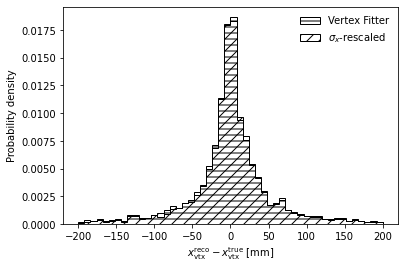

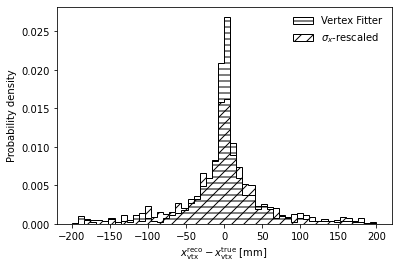

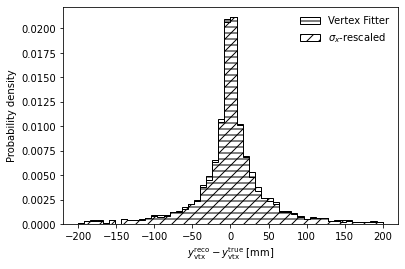

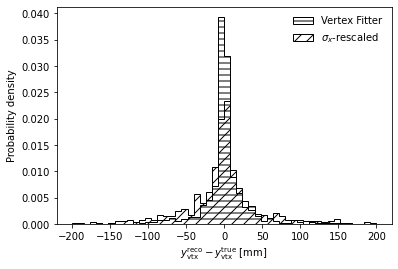

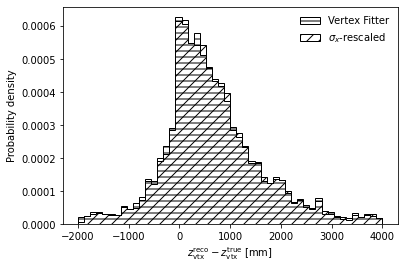

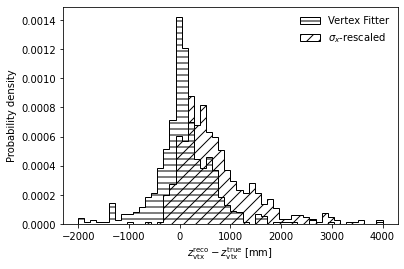

In [24]:
bias_boundary_dictionary = {
    'x': (-200,200),
    'y': (-200,200),
    'z': (-2000,4000),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': f'${comp}^\mathrm{{reco}}_\mathrm{{vtx}} - {comp}^\mathrm{{true}}_\mathrm{{vtx}}$ [mm]',
        'plot_title': f'$\Lambda^0$ decay vertex bias: {comp} component',
        'file_name': f'VF_vs_2DX_Lambda_endvertex_{comp}_bias',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_algorithm_comparison(
        df_events,
        (df_events[fitted_feature + '_VF'] - df_events[true_feature]),
        (df_events[fitted_feature + '_SIGMAX'] - df_events[true_feature]),
        **plot_args)